In [39]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jp797498e/twitter-entity-sentiment-analysis")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\ASUS\.cache\kagglehub\datasets\jp797498e\twitter-entity-sentiment-analysis\versions\2


In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

from wordcloud import WordCloud
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import nltk
from nltk import word_tokenize, pos_tag
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

In [41]:
nltk.download('wordnet')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [42]:
train_filename = "twitter_training.csv"
test_filename = "twitter_validation.csv"

df_train = pd.read_csv(f"{path}/{train_filename}", header = None)
df_test = pd.read_csv(f"{path}/{test_filename}", header = None)

In [43]:
df_train.head()

,0,1,2,3
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [44]:
df_train = df_train.dropna()
df_test = df_test.dropna()

In [45]:
df_train = df_train[[2, 3]]
df_train.head()

,2,3
0,Positive,im getting on borderlands and i will murder yo...
1,Positive,I am coming to the borders and I will kill you...
2,Positive,im getting on borderlands and i will kill you ...
3,Positive,im coming on borderlands and i will murder you...
4,Positive,im getting on borderlands 2 and i will murder ...


In [46]:
df_test = df_test[[2, 3]]
df_test.head()

,2,3
0,Irrelevant,I mentioned on Facebook that I was struggling ...
1,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,Negative,@Microsoft Why do I pay for WORD when it funct...
3,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,Neutral,Now the President is slapping Americans in the...


In [47]:
df_train = df_train[df_train[2] != "Irrelevant"]
df_train.head()

,2,3
0,Positive,im getting on borderlands and i will murder yo...
1,Positive,I am coming to the borders and I will kill you...
2,Positive,im getting on borderlands and i will kill you ...
3,Positive,im coming on borderlands and i will murder you...
4,Positive,im getting on borderlands 2 and i will murder ...


In [48]:
df_test = df_test[df_test[2] != 'Irrelevant']
df_test.head()

,2,3
1,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,Negative,@Microsoft Why do I pay for WORD when it funct...
3,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,Neutral,Now the President is slapping Americans in the...
5,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...


In [49]:
def get_pos_tag(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [50]:
class LemmaTokenize:
  def __init__(self):
    self.wnl = WordNetLemmatizer()
  def __call__(self, doc):
    tokens = word_tokenize(doc)
    word_and_tag = pos_tag(tokens)
    return [self.wnl.lemmatize(word, pos=get_pos_tag(tag)) for word, tag in word_and_tag]

In [51]:
vectorizer = TfidfVectorizer(tokenizer = LemmaTokenize())
X_train = vectorizer.fit_transform(df_train[3])
X_test = vectorizer.transform(df_test[3])

c:\Users\ASUS\anaconda3\envs\main-env\lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [52]:
len(df_train + df_test)

61208

In [57]:
target_map = {'Negative': 0, 'Neutral': 1, 'Positive': 2}

In [59]:
y_train = df_train[2].map(target_map)
y_test = df_test[2].map(target_map)


In [63]:
model = LogisticRegression(max_iter=2000)
model.fit(X_train, y_train)

print(f"Train acc: {model.score(X_train, y_train)}")
print(f"Test acc: {model.score(X_test, y_test)}")

Train acc: 0.8696847237447032
Test acc: 0.8961352657004831


In [65]:
def plot_cm(cm):
  classes = ["negative", "neutral", "positive"]
  df_cm = pd.DataFrame(cm, index = classes, columns = classes)
  ax = sn.heatmap(df_cm, annot = True, fmt = 'g')
  ax.set_xlabel("Predicted")
  ax.set_ylabel("True")

In [67]:
P_train = model.predict(X_train)
P_test = model.predict(X_test)

cm_train = confusion_matrix(y_train, P_train, normalize = 'true')
cm_test = confusion_matrix(y_test, P_test, normalize = 'true')

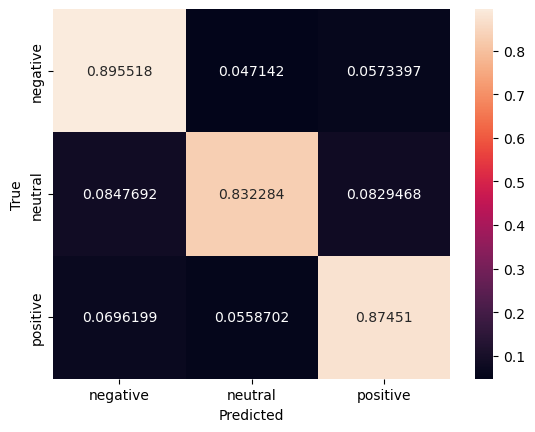

In [68]:
plot_cm(cm_train)

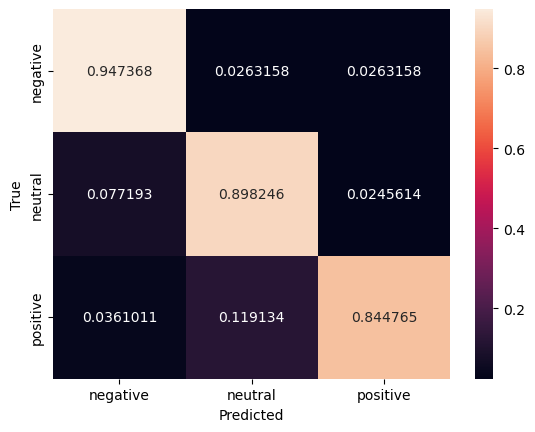

In [69]:
plot_cm(cm_test)

In [70]:
Prob_train = model.predict_proba(X_train)
Prob_test = model.predict_proba(X_test)

print(f"Train AUC: {roc_auc_score(y_train, Prob_train, multi_class='ovr')}")
print(f"Test AUC: {roc_auc_score(y_test, Prob_test, multi_class='ovr')}")

Train AUC: 0.9638066629629662
Test AUC: 0.9766926300406523


In [85]:
def visualize(label):
  words = ""
  for word in df_train[df_train[2] == label.capitalize()][3]:
    words += word.lower() + " "
  wordcloud = WordCloud(width = 800, height = 800).generate(words)
  plt.imshow(wordcloud)
  plt.axis('off')
  plt.title(label)

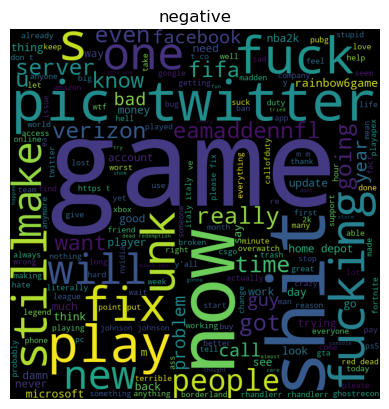

In [82]:
visualize("negative")

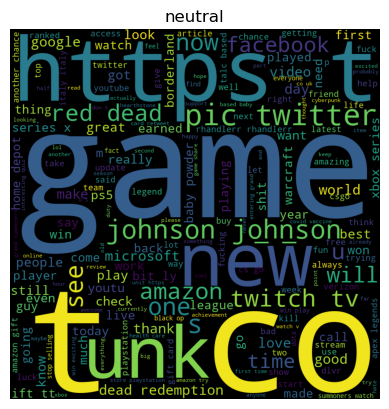

In [83]:
visualize("neutral")

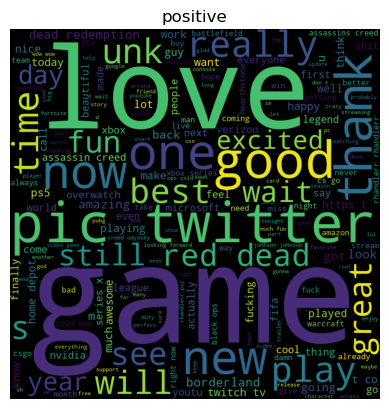

In [84]:
visualize('positive')

array([0], dtype=int64)